In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

/home/njvh/Documents/Science/ta/takeishi/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("../data/mu-frac-iron-shower-signals.csv")
x_columns = df.columns[2:-2]
y_columns = df.columns[-2:]

In [3]:
CUT_EXTREME_VALUES = True
PREDICT_TOP = True

In [4]:
X = df[x_columns].to_numpy()
y = df[y_columns].to_numpy()

y = y[:, 0 if PREDICT_TOP else 1]


if CUT_EXTREME_VALUES:
    classifier = xgb.Booster()
    classifier.load_model("../trained_models/xgboost-classifier.model")

    dall = xgb.DMatrix(X)
    class_predicted = classifier.predict(dall)
    mask = class_predicted > 0.5
    # eps = 0.03
    # mask = np.logical_and(y > eps, y < 1 - eps)
    X = X[mask, :]
    y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [6]:
param = {
    'max_depth': 8,
    'learning_rate': 0.05,
    'min_child_weight': 3.0,
    'subsample': 0.8,
    'objective': 'reg:logistic',
    'eval_metric': 'rmse',
}

epochs = 500

In [7]:
model = xgb.train(param, dtrain, num_boost_round=epochs, evals=[(dtest, 'test')], verbose_eval=5, early_stopping_rounds=15)

[0]	test-rmse:0.29397
[5]	test-rmse:0.26028
[10]	test-rmse:0.23752
[15]	test-rmse:0.22243
[20]	test-rmse:0.21263
[25]	test-rmse:0.20626
[30]	test-rmse:0.20215
[35]	test-rmse:0.19947
[40]	test-rmse:0.19772
[45]	test-rmse:0.19651
[50]	test-rmse:0.19569
[55]	test-rmse:0.19513
[60]	test-rmse:0.19472
[65]	test-rmse:0.19441
[70]	test-rmse:0.19418
[75]	test-rmse:0.19400
[80]	test-rmse:0.19389
[85]	test-rmse:0.19381
[90]	test-rmse:0.19374
[95]	test-rmse:0.19369
[100]	test-rmse:0.19362
[105]	test-rmse:0.19359
[110]	test-rmse:0.19353
[115]	test-rmse:0.19351
[120]	test-rmse:0.19348
[125]	test-rmse:0.19347
[130]	test-rmse:0.19344
[135]	test-rmse:0.19341
[140]	test-rmse:0.19341
[145]	test-rmse:0.19341
[150]	test-rmse:0.19340
[155]	test-rmse:0.19338
[160]	test-rmse:0.19338
[165]	test-rmse:0.19338
[170]	test-rmse:0.19337
[175]	test-rmse:0.19336
[180]	test-rmse:0.19336
[185]	test-rmse:0.19335
[190]	test-rmse:0.19334
[195]	test-rmse:0.19333
[200]	test-rmse:0.19333
[205]	test-rmse:0.19332
[210]	test-rms

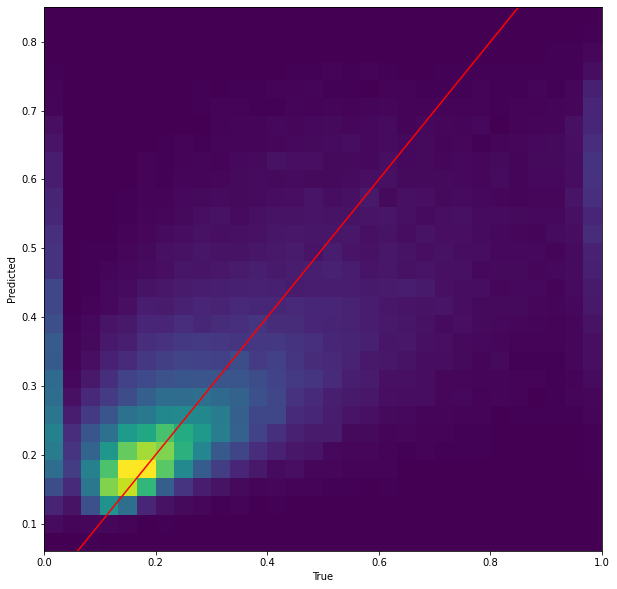

In [8]:
y_pred = model.predict(dtest)
y_true = dtest.get_label()

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist2d(y_true, y_pred, bins=30) # , norm=LogNorm())
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.plot([0, 1], [0, 1], color='red')

plt.savefig(f"../pics/xgboost-evaluation-{param['objective']}-no-extremes.png", bbox_inches='tight')